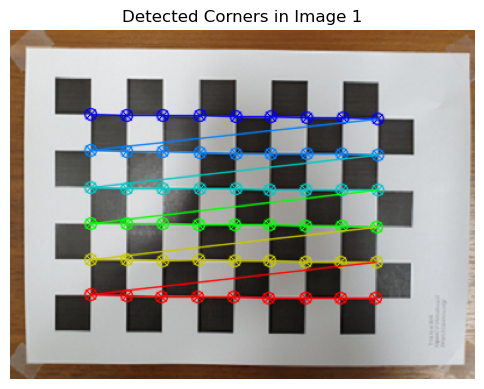

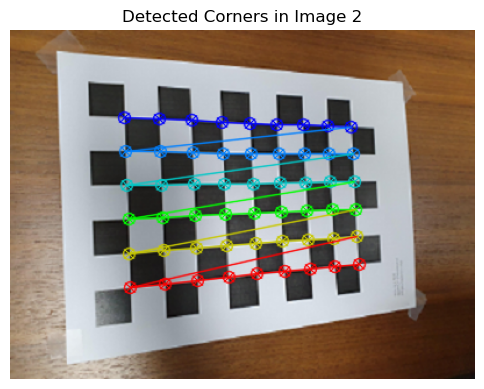

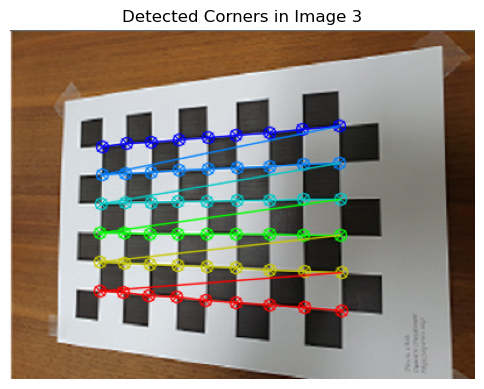

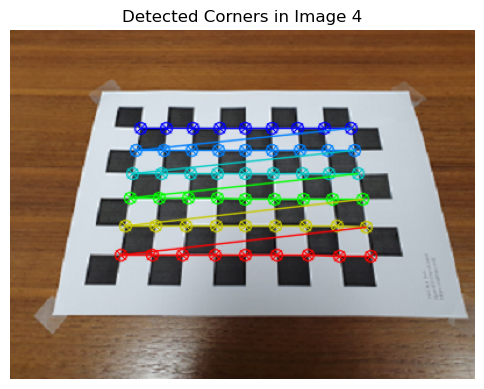

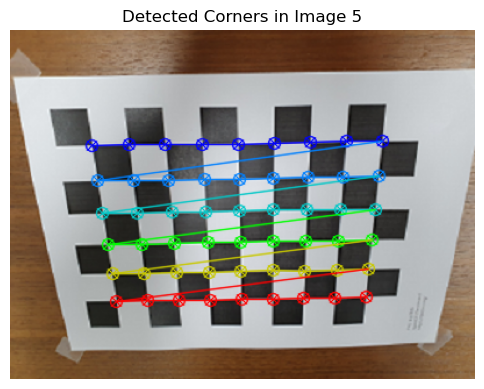

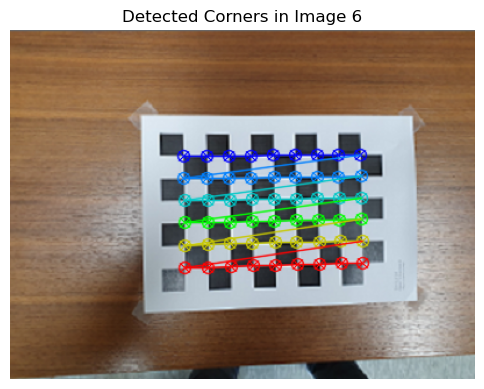


==== Camera Calibration Results ====
Intrinsic Camera Matrix:
 [[308.23767952   0.         199.86454642]
 [  0.         309.3959058  144.63307277]
 [  0.           0.           1.        ]]

Distortion Coefficients:
 [ 3.55585487e-01 -2.24560472e+00 -2.32254507e-03 -5.30490329e-05
  4.10638959e+00]

Average Reprojection Error: 0.05456951496715015

Calibration results saved to: C:\Users\hassa\calibration_report.txt


In [4]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import os

# Define the chessboard configuration
pattern_size = (9, 6)  # Number of internal corners in the checkerboard (width, height)
square_length = 1.0  # Size of a square in chosen units (e.g., mm, cm)

# Generate 3D world coordinates for the checkerboard pattern
world_points = np.zeros((pattern_size[0] * pattern_size[1], 3), dtype=np.float32)
world_points[:, :2] = np.indices((pattern_size[0], pattern_size[1])).T.reshape(-1, 2) * square_length

# Lists to store object points (3D) and image points (2D)
object_points = []  # Real-world coordinates
image_points = []  # Corresponding image coordinates

# Load calibration images
image_files = glob.glob(r"C:\Users\hassa\Downloads\Assignment 1 Sparse 3D Reconstruction\cal\*.png")[:6]

# Check if images were found
if not image_files:
    raise FileNotFoundError("No calibration images found in the specified directory!")

# Process each calibration image
for idx, file in enumerate(image_files):
    image = cv2.imread(file)
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect chessboard corners
    found, corners = cv2.findChessboardCorners(grayscale, pattern_size, None)
    
    if found:
        object_points.append(world_points)
        image_points.append(corners)
        
        # Refine corner detection for accuracy
        corners_subpix = cv2.cornerSubPix(grayscale, corners, (11, 11), (-1, -1), 
                                          criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        
        # Convert image to RGB and visualize detected corners
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        cv2.drawChessboardCorners(image_rgb, pattern_size, corners_subpix, found)
        
        plt.figure(figsize=(6, 6))
        plt.imshow(image_rgb)
        plt.title(f"Detected Corners in Image {idx+1}")
        plt.axis("off")
        plt.show()

# Close OpenCV windows
cv2.destroyAllWindows()

# Perform camera calibration
success, camera_matrix, distortion_coeffs, rotation_vecs, translation_vecs = cv2.calibrateCamera(
    object_points, image_points, grayscale.shape[::-1], None, None
)

if not success:
    raise RuntimeError("Camera calibration failed!")

# Compute reprojection error
total_error = 0
for i in range(len(object_points)):
    projected_points, _ = cv2.projectPoints(object_points[i], rotation_vecs[i], translation_vecs[i], camera_matrix, distortion_coeffs)
    error = cv2.norm(image_points[i], projected_points, cv2.NORM_L2) / len(projected_points)
    total_error += error

average_error = total_error / len(object_points)

# Save results to a report file
report_path = os.path.join(os.getcwd(), "calibration_report.txt")
with open(report_path, "w") as report_file:
    report_file.write("==== Camera Calibration Results ====\n")
    report_file.write("Intrinsic Camera Matrix:\n")
    report_file.write(str(camera_matrix) + "\n\n")
    report_file.write("Distortion Coefficients:\n")
    report_file.write(str(distortion_coeffs.ravel()) + "\n\n")
    report_file.write("Extrinsic Parameters (Rotation and Translation Vectors per Image):\n")
    
    for i, (rvec, tvec) in enumerate(zip(rotation_vecs, translation_vecs)):
        report_file.write(f"\nImage {i+1}:\n")
        report_file.write(f"Rotation Vector:\n{rvec.ravel()}\n")
        report_file.write(f"Translation Vector:\n{tvec.ravel()}\n")
    
    report_file.write("\nCalibration Accuracy:\n")
    report_file.write(f"Average Reprojection Error: {average_error:.6f}\n")

# Display final results
print("\n==== Camera Calibration Results ====")
print("Intrinsic Camera Matrix:\n", camera_matrix)
print("\nDistortion Coefficients:\n", distortion_coeffs.ravel())
print("\nAverage Reprojection Error:", average_error)
print("\nCalibration results saved to:", report_path)
